In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数

beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0.5
prior=7

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [4]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2228, dtype=torch.float64)

tensor(0.2055, dtype=torch.float64)

tensor(0.2209, dtype=torch.float64)

In [5]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [6]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=7
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr,ga= config["lambda1"], config["lambda2"],config["lr"],config["ga"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "ga":tune.choice([0.3,0.4,0.5])
    }
    result = tune.run(
        train_model,  
        config=config, 
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


2022-11-17 12:13:29,359	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8269 
2022-11-17 12:13:30,194	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_316d8_00000,TERMINATED,10.224.0.12:7555,0.3,0.05,0.001,0.8,1,12.0485,1.39266
train_model_316d8_00001,TERMINATED,10.224.0.12:7581,0.4,0.03,0.002,0.8,1,12.4,1.2387
train_model_316d8_00002,TERMINATED,10.224.0.12:7583,0.3,0.05,0.002,0.8,1,12.2035,1.34112
train_model_316d8_00003,TERMINATED,10.224.0.12:7585,0.4,0.05,0.003,0.8,1,12.9955,1.25059
train_model_316d8_00004,TERMINATED,10.224.0.12:7587,0.4,0.03,0.001,0.8,1,12.4278,1.38496
train_model_316d8_00005,TERMINATED,10.224.0.12:7588,0.3,0.03,0.003,0.6,1,12.4351,1.34435
train_model_316d8_00006,TERMINATED,10.224.0.12:7591,0.5,0.03,0.001,0.7,1,12.5136,1.39784
train_model_316d8_00007,TERMINATED,10.224.0.12:7593,0.3,0.05,0.002,0.8,1,12.733,1.34112
train_model_316d8_00008,TERMINATED,10.224.0.12:7595,0.3,0.04,0.001,0.7,1,12.569,1.59065
train_model_316d8_00009,TERMINATED,10.224.0.12:7597,0.3,0.05,0.001,0.6,1,13.1333,1.72195


(raylet) [2022-11-17 12:13:39,258 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 45654016; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_316d8_00000:
  date: 2022-11-17_12-13-44
  done: false
  experiment_id: 61e0660ed8984034b5a2803ab9227c37
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.392663061618805
  node_ip: 10.224.0.12
  pid: 7555
  time_since_restore: 12.048543214797974
  time_this_iter_s: 12.048543214797974
  time_total_s: 12.048543214797974
  timestamp: 1668658424
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00000
  warmup_time: 0.0038225650787353516
  
Result for train_model_316d8_00000:
  date: 2022-11-17_12-13-44
  done: true
  experiment_id: 61e0660ed8984034b5a2803ab9227c37
  experiment_tag: 0_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.392663061618805
  node_ip: 10.224.0.12
  pid: 7555
  time_since_restore: 12.048543214797974
  time_this_iter_s: 12.048543214797974
  time_total_s: 12.048543214797974
  timestamp: 1668658424
  timestep

Result for train_model_316d8_00021:
  date: 2022-11-17_12-13-48
  done: false
  experiment_id: 016cefddcf374b7293d736b59d414d03
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.57268226146698
  node_ip: 10.224.0.12
  pid: 7621
  time_since_restore: 12.146016597747803
  time_this_iter_s: 12.146016597747803
  time_total_s: 12.146016597747803
  timestamp: 1668658428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00021
  warmup_time: 0.008533716201782227
  
Result for train_model_316d8_00010:
  date: 2022-11-17_12-13-48
  done: false
  experiment_id: ac4718625ad445619263f0288575d0e7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5616935253143311
  node_ip: 10.224.0.12
  pid: 7599
  time_since_restore: 12.401878118515015
  time_this_iter_s: 12.401878118515015
  time_total_s: 12.401878118515015
  timestamp: 1668658428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00010
  w

Result for train_model_316d8_00027:
  date: 2022-11-17_12-13-48
  done: true
  experiment_id: 8e9a160972f54730957428b45d31997c
  experiment_tag: 27_ga=0.4000,lambda1=0.0300,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.265481448173523
  node_ip: 10.224.0.12
  pid: 7633
  time_since_restore: 12.451066970825195
  time_this_iter_s: 12.451066970825195
  time_total_s: 12.451066970825195
  timestamp: 1668658428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00027
  warmup_time: 0.009313821792602539
  
Result for train_model_316d8_00003:
  date: 2022-11-17_12-13-48
  done: false
  experiment_id: ec66b233b6d64b1cb908728a54ba9b92
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2505903959274292
  node_ip: 10.224.0.12
  pid: 7585
  time_since_restore: 12.995473861694336
  time_this_iter_s: 12.995473861694336
  time_total_s: 12.995473861694336
  timestamp: 1668658428
  timeste

(raylet) [2022-11-17 12:13:49,265 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 44683264; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_316d8_00016:
  date: 2022-11-17_12-13-49
  done: false
  experiment_id: 1c841c04dd6c4403b9d5457d1ab6f4f5
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3978378772735596
  node_ip: 10.224.0.12
  pid: 7611
  time_since_restore: 13.08567500114441
  time_this_iter_s: 13.08567500114441
  time_total_s: 13.08567500114441
  timestamp: 1668658429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00016
  warmup_time: 0.0072307586669921875
  
Result for train_model_316d8_00016:
  date: 2022-11-17_12-13-49
  done: true
  experiment_id: 1c841c04dd6c4403b9d5457d1ab6f4f5
  experiment_tag: 16_ga=0.5000,lambda1=0.0300,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3978378772735596
  node_ip: 10.224.0.12
  pid: 7611
  time_since_restore: 13.08567500114441
  time_this_iter_s: 13.08567500114441
  time_total_s: 13.08567500114441
  timestamp: 1668658429
  timesteps_s

(raylet) [2022-11-17 12:13:59,274 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 44195840; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_316d8_00036:
  date: 2022-11-17_12-13-59
  done: false
  experiment_id: e77d0cdc5b6f4b74a447b3d7eebe2e90
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.361240839958191
  node_ip: 10.224.0.12
  pid: 7591
  time_since_restore: 11.219699382781982
  time_this_iter_s: 11.219699382781982
  time_total_s: 11.219699382781982
  timestamp: 1668658439
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00036
  warmup_time: 0.005018949508666992
  
Result for train_model_316d8_00036:
  date: 2022-11-17_12-13-59
  done: true
  experiment_id: e77d0cdc5b6f4b74a447b3d7eebe2e90
  experiment_tag: 36_ga=0.5000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.361240839958191
  node_ip: 10.224.0.12
  pid: 7591
  time_since_restore: 11.219699382781982
  time_this_iter_s: 11.219699382781982
  time_total_s: 11.219699382781982
  timestamp: 1668658439
  timestep

Result for train_model_316d8_00035:
  date: 2022-11-17_12-14-00
  done: false
  experiment_id: 879197390ed74b28bd63ac13fa87f5bf
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2505903959274292
  node_ip: 10.224.0.12
  pid: 7583
  time_since_restore: 11.939870834350586
  time_this_iter_s: 11.939870834350586
  time_total_s: 11.939870834350586
  timestamp: 1668658440
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00035
  warmup_time: 0.004832029342651367
  
Result for train_model_316d8_00052:
  date: 2022-11-17_12-14-00
  done: false
  experiment_id: a995fcba1b2a47cb965a7d5a422a0c3a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4407384872436524
  node_ip: 10.224.0.12
  pid: 7637
  time_since_restore: 11.308086156845093
  time_this_iter_s: 11.308086156845093
  time_total_s: 11.308086156845093
  timestamp: 1668658440
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00052
 

Result for train_model_316d8_00058:
  date: 2022-11-17_12-14-00
  done: true
  experiment_id: ec66b233b6d64b1cb908728a54ba9b92
  experiment_tag: 58_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6086426019668578
  node_ip: 10.224.0.12
  pid: 7585
  time_since_restore: 11.518598794937134
  time_this_iter_s: 11.518598794937134
  time_total_s: 11.518598794937134
  timestamp: 1668658440
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00058
  warmup_time: 0.008715391159057617
  
Result for train_model_316d8_00054:
  date: 2022-11-17_12-14-00
  done: false
  experiment_id: 539540a4915a412b9769b8367394440e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3650067687034606
  node_ip: 10.224.0.12
  pid: 7623
  time_since_restore: 11.690554141998291
  time_this_iter_s: 11.690554141998291
  time_total_s: 11.690554141998291
  timestamp: 1668658440
  timest

Result for train_model_316d8_00037:
  date: 2022-11-17_12-14-01
  done: false
  experiment_id: 0c6b8c0dd005435a85015a3fadccde1f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6779948472976685
  node_ip: 10.224.0.12
  pid: 7601
  time_since_restore: 13.247443914413452
  time_this_iter_s: 13.247443914413452
  time_total_s: 13.247443914413452
  timestamp: 1668658441
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00037
  warmup_time: 0.009431123733520508
  
Result for train_model_316d8_00037:
  date: 2022-11-17_12-14-01
  done: true
  experiment_id: 0c6b8c0dd005435a85015a3fadccde1f
  experiment_tag: 37_ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6779948472976685
  node_ip: 10.224.0.12
  pid: 7601
  time_since_restore: 13.247443914413452
  time_this_iter_s: 13.247443914413452
  time_total_s: 13.247443914413452
  timestamp: 1668658441
  timest

(raylet) [2022-11-17 12:14:09,288 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 43155456; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_316d8_00072:
  date: 2022-11-17_12-14-10
  done: false
  experiment_id: 236a4d4168934b1abff417cf3a23a306
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3789867281913757
  node_ip: 10.224.0.12
  pid: 7615
  time_since_restore: 10.955217361450195
  time_this_iter_s: 10.955217361450195
  time_total_s: 10.955217361450195
  timestamp: 1668658450
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00072
  warmup_time: 0.004087686538696289
  
Result for train_model_316d8_00072:
  date: 2022-11-17_12-14-10
  done: true
  experiment_id: 236a4d4168934b1abff417cf3a23a306
  experiment_tag: 72_ga=0.4000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3789867281913757
  node_ip: 10.224.0.12
  pid: 7615
  time_since_restore: 10.955217361450195
  time_this_iter_s: 10.955217361450195
  time_total_s: 10.955217361450195
  timestamp: 1668658450
  timest

Result for train_model_316d8_00070:
  date: 2022-11-17_12-14-11
  done: false
  experiment_id: 8f840208df2545f09c5ff1f438d8bd05
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.427710199356079
  node_ip: 10.224.0.12
  pid: 7587
  time_since_restore: 11.777341604232788
  time_this_iter_s: 11.777341604232788
  time_total_s: 11.777341604232788
  timestamp: 1668658451
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00070
  warmup_time: 0.004282951354980469
  
Result for train_model_316d8_00070:
  date: 2022-11-17_12-14-11
  done: true
  experiment_id: 8f840208df2545f09c5ff1f438d8bd05
  experiment_tag: 70_ga=0.3000,lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.427710199356079
  node_ip: 10.224.0.12
  pid: 7587
  time_since_restore: 11.777341604232788
  time_this_iter_s: 11.777341604232788
  time_total_s: 11.777341604232788
  timestamp: 1668658451
  timestep

Result for train_model_316d8_00086:
  date: 2022-11-17_12-14-12
  done: false
  experiment_id: e30d3a7099fc46489e104ab6e8841d20
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3789867281913757
  node_ip: 10.224.0.12
  pid: 7641
  time_since_restore: 11.504094362258911
  time_this_iter_s: 11.504094362258911
  time_total_s: 11.504094362258911
  timestamp: 1668658452
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00086
  warmup_time: 0.004621744155883789
  
Result for train_model_316d8_00086:
  date: 2022-11-17_12-14-12
  done: true
  experiment_id: e30d3a7099fc46489e104ab6e8841d20
  experiment_tag: 86_ga=0.4000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3789867281913757
  node_ip: 10.224.0.12
  pid: 7641
  time_since_restore: 11.504094362258911
  time_this_iter_s: 11.504094362258911
  time_total_s: 11.504094362258911
  timestamp: 1668658452
  timest

Result for train_model_316d8_00078:
  date: 2022-11-17_12-14-12
  done: false
  experiment_id: e046cc5db1c749ea9f4d2c314f731d43
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3762701034545899
  node_ip: 10.224.0.12
  pid: 7593
  time_since_restore: 12.703909158706665
  time_this_iter_s: 12.703909158706665
  time_total_s: 12.703909158706665
  timestamp: 1668658452
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 316d8_00078
  warmup_time: 0.007933855056762695
  
Result for train_model_316d8_00078:
  date: 2022-11-17_12-14-12
  done: true
  experiment_id: e046cc5db1c749ea9f4d2c314f731d43
  experiment_tag: 78_ga=0.4000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3762701034545899
  node_ip: 10.224.0.12
  pid: 7593
  time_since_restore: 12.703909158706665
  time_this_iter_s: 12.703909158706665
  time_total_s: 12.703909158706665
  timestamp: 1668658452
  timest

2022-11-17 12:14:13,542	INFO tune.py:758 -- Total run time: 43.35 seconds (43.15 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
316d8_00000          1.392663         12.048543  True            None   
316d8_00001          1.238697         12.400050  True            None   
316d8_00002          1.341123         12.203502  True            None   
316d8_00003          1.250590         12.995474  True            None   
316d8_00004          1.384957         12.427782  True            None   
...                       ...               ...   ...             ...   
316d8_00091          1.342909         11.133798  True            None   
316d8_00092          1.263480         11.190406  True            None   
316d8_00093          1.392663         11.295407  True            None   
316d8_00094          1.540259         11.854292  True            None   
316d8_00095          1.277465         11.037121  True            N

(raylet) [2022-11-17 12:14:19,296 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 42422272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:14:29,304 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 42156032; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:14:39,330 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 41885696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:14:49,339 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 41824256; capacity: 29394726912. Object creation will fail if spilling is re

In [7]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.1931072473526


{'lr': 0.6, 'lambda1': 0.03, 'lambda2': 0.003, 'ga': 0.5}

(raylet) [2022-11-17 12:15:59,427 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 40243200; capacity: 29394726912. Object creation will fail if spilling is required.


In [8]:
################## second step##################

prior=7
#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1440, grad_fn=<AddBackward0>)

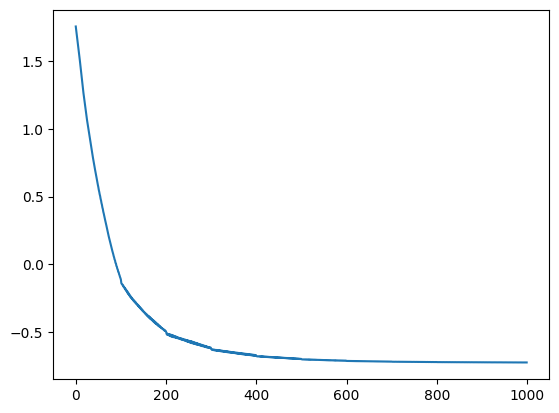

(raylet) [2022-11-17 12:16:09,435 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 40177664; capacity: 29394726912. Object creation will fail if spilling is required.


In [9]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [10]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.6593e+00, -1.4004e+00, -1.3511e+00, -1.7917e+00, -9.4932e-01,
         -8.8978e-01, -1.6118e+00, -2.3615e-01, -5.3958e-01,  6.3419e-01,
         -2.8047e-05,  7.9894e-06,  3.8674e-05,  5.2063e-06,  7.5528e-05,
         -4.3815e-05, -9.6215e-06,  1.4618e-05, -8.2564e-05, -4.9696e-05,
          7.7709e-05,  7.4905e-05,  2.4202e-05, -4.3033e-05, -5.0620e-06,
          1.2678e-05,  6.7517e-06,  2.4886e-05,  7.4100e-05, -9.4958e-05,
          1.0878e-05, -3.4848e-05,  7.0118e-05, -1.6594e-05,  7.4400e-06,
          3.9784e-05, -8.6605e-05,  1.1183e-05, -1.7140e-05, -7.8489e-05,
          1.5023e-05, -1.0092e-05,  9.4772e-05,  1.3288e-05,  5.2682e-02,
         -4.0177e-05, -2.6727e-05,  3.8968e-05,  2.1063e-05, -1.1269e-05,
         -1.7015e-05,  1.5483e-05,  9.5014e-05,  1.2437e-05, -2.1851e-05,
          3.7737e-03,  7.4170e-05, -5.4937e-05,  5.6415e-05,  3.4063e-05,
          1.1062e-05, -8.1702e-05, -2.6090e-01,  1.7852e-05, -1.9420e-05,
         -2.8687e-05,  9.1869e-05, -1.

tensor([[-1.6593e+00, -1.4004e+00, -1.3511e+00, -1.7917e+00, -9.4932e-01,
         -8.8978e-01, -1.6118e+00, -2.3615e-01, -5.3958e-01,  6.3419e-01,
         -2.8047e-05,  7.9894e-06,  3.8674e-05,  5.2063e-06,  7.5528e-05,
         -4.3815e-05, -9.6215e-06,  1.4618e-05, -8.2564e-05, -4.9696e-05,
          7.7709e-05,  7.4905e-05,  2.4202e-05, -4.3033e-05, -5.0620e-06,
          1.2678e-05,  6.7517e-06,  2.4886e-05,  7.4100e-05, -9.4958e-05,
          1.0878e-05, -3.4848e-05,  7.0118e-05, -1.6594e-05,  7.4400e-06,
          3.9784e-05, -8.6605e-05,  1.1183e-05, -1.7140e-05, -7.8489e-05,
          1.5023e-05, -1.0092e-05,  9.4772e-05,  1.3288e-05,  5.2682e-02,
         -4.0177e-05, -2.6727e-05,  3.8968e-05,  2.1063e-05, -1.1269e-05,
         -1.7015e-05,  1.5483e-05,  9.5014e-05,  1.2437e-05, -2.1851e-05,
          3.7737e-03,  7.4170e-05, -5.4937e-05,  5.6415e-05,  3.4063e-05,
          1.1062e-05, -8.1702e-05, -2.6090e-01,  1.7852e-05, -1.9420e-05,
         -2.8687e-05,  9.1869e-05, -1.

tensor([[-1.7085e+00, -1.0569e+00, -1.5415e+00, -1.8067e+00, -1.0947e+00,
         -7.0008e-01, -1.3910e+00, -5.0275e-01, -7.1159e-01,  8.0811e-01,
          1.1232e-05, -5.5785e-07,  2.2167e-07,  3.3756e-06,  4.5759e-07,
          1.5957e-05, -1.8855e-06, -2.1538e-05, -1.0954e-07, -9.5298e-07,
          9.8011e-07,  1.3763e-05, -9.1906e-06,  2.5401e-05, -3.0146e-06,
         -1.2964e-06, -7.6550e-06, -2.4365e-06, -7.0594e-06, -1.3235e-05,
         -2.5635e-05, -3.1785e-06,  6.2231e-06,  7.0604e-06,  3.9790e-07,
         -1.2332e-05,  1.9715e-05, -1.1885e-05, -1.5451e-07, -1.0711e-07,
         -9.0352e-07, -1.2040e-06, -9.4085e-06, -7.9662e-07,  9.7261e-02,
         -1.3290e-05,  2.2774e-06, -5.2432e-06, -2.6569e-06,  4.2285e-07,
          9.1987e-07, -4.3164e-06, -1.6430e-05, -9.9853e-06,  8.9995e-06,
          1.4933e-02, -1.2094e-07, -5.1675e-06,  2.1967e-07, -4.2100e-06,
         -8.2737e-07,  2.0530e-06, -7.4895e-01, -3.3627e-07, -3.8079e-06,
         -4.8593e-06, -2.1638e-05, -7.

In [11]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.1440)

tensor(0.0674)

tensor(0.0128)

tensor(0.0639)

In [12]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[74,  1],
       [ 1, 84]])

array([[78,  0],
       [ 0, 82]])

array([[69,  1],
       [ 1, 89]])

In [13]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
         "eta": tune.choice([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_95068_00000,TERMINATED,10.224.0.12:10218,0.7,0.05,0.001,0.6,1,16.1238,0.910424
train_model_95068_00001,TERMINATED,10.224.0.12:10787,0.1,0.03,0.002,0.7,1,15.3467,0.87821
train_model_95068_00002,TERMINATED,10.224.0.12:10789,1,0.04,0.002,0.8,1,15.4212,0.91617
train_model_95068_00003,TERMINATED,10.224.0.12:10791,0,0.05,0.003,0.7,1,15.2598,0.877876
train_model_95068_00004,TERMINATED,10.224.0.12:10793,0.6,0.04,0.001,0.7,1,15.3462,0.912277
train_model_95068_00005,TERMINATED,10.224.0.12:10795,1,0.03,0.002,0.6,1,15.1482,0.884307
train_model_95068_00006,TERMINATED,10.224.0.12:10797,0.6,0.05,0.003,0.7,1,15.4472,0.910318
train_model_95068_00007,TERMINATED,10.224.0.12:10799,0,0.03,0.001,0.7,1,15.4002,0.873932
train_model_95068_00008,TERMINATED,10.224.0.12:10801,0.9,0.05,0.002,0.7,1,14.9205,0.916124
train_model_95068_00009,TERMINATED,10.224.0.12:10803,0.4,0.04,0.001,0.6,1,14.9505,0.88525


(raylet) [2022-11-17 12:16:19,446 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 39481344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:16:29,464 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 38199296; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00000:
  date: 2022-11-17_12-16-35
  done: false
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9104241810407897
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 16.12376642227173
  time_this_iter_s: 16.12376642227173
  time_total_s: 16.12376642227173
  timestamp: 1668658595
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00000'
  warmup_time: 0.0037081241607666016
  
Result for train_model_95068_00000:
  date: 2022-11-17_12-16-35
  done: true
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  experiment_tag: 0_eta=0.7000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9104241810407897
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 16.12376642227173
  time_this_iter_s: 16.12376642227173
  time_total_s: 16.12376642227173
  timestamp: 1668658595
  timesteps

Result for train_model_95068_00017:
  date: 2022-11-17_12-16-39
  done: false
  experiment_id: b69f2465d2904a859f9bf0befdd99c2c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8816896459563361
  node_ip: 10.224.0.12
  pid: 10819
  time_since_restore: 15.145323753356934
  time_this_iter_s: 15.145323753356934
  time_total_s: 15.145323753356934
  timestamp: 1668658599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00017'
  warmup_time: 0.006492137908935547
  
Result for train_model_95068_00004:
  date: 2022-11-17_12-16-39
  done: false
  experiment_id: 662c3e52db5b442bb2c246ea82c0d661
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9122772614918316
  node_ip: 10.224.0.12
  pid: 10793
  time_since_restore: 15.346179485321045
  time_this_iter_s: 15.346179485321045
  time_total_s: 15.346179485321045
  timestamp: 1668658599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_0000

(raylet) [2022-11-17 12:16:39,470 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 37531648; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00016:
  date: 2022-11-17_12-16-39
  done: false
  experiment_id: b5da298671534d97ba1e1cba35d3837b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8718739603691402
  node_ip: 10.224.0.12
  pid: 10817
  time_since_restore: 15.223531484603882
  time_this_iter_s: 15.223531484603882
  time_total_s: 15.223531484603882
  timestamp: 1668658599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00016'
  warmup_time: 0.0048482418060302734
  
Result for train_model_95068_00016:
  date: 2022-11-17_12-16-39
  done: true
  experiment_id: b5da298671534d97ba1e1cba35d3837b
  experiment_tag: 16_eta=0.1000,lambda1=0.0300,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8718739603691402
  node_ip: 10.224.0.12
  pid: 10817
  time_since_restore: 15.223531484603882
  time_this_iter_s: 15.223531484603882
  time_total_s: 15.223531484603882
  timestamp: 1668658599
  ti

Result for train_model_95068_00012:
  date: 2022-11-17_12-16-40
  done: false
  experiment_id: 5db3cab6bf714505bf4b12d5dcaaebdc
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8781257934312288
  node_ip: 10.224.0.12
  pid: 10809
  time_since_restore: 15.649356365203857
  time_this_iter_s: 15.649356365203857
  time_total_s: 15.649356365203857
  timestamp: 1668658600
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00012'
  warmup_time: 0.008652448654174805
  
Result for train_model_95068_00012:
  date: 2022-11-17_12-16-40
  done: true
  experiment_id: 5db3cab6bf714505bf4b12d5dcaaebdc
  experiment_tag: 12_eta=0,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8781257934312288
  node_ip: 10.224.0.12
  pid: 10809
  time_since_restore: 15.649356365203857
  time_this_iter_s: 15.649356365203857
  time_total_s: 15.649356365203857
  timestamp: 1668658600
  timestep

Result for train_model_95068_00020:
  date: 2022-11-17_12-16-42
  done: false
  experiment_id: 24693f88b21e4886936db695b72df10d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9080181590278723
  node_ip: 10.224.0.12
  pid: 10825
  time_since_restore: 17.60679817199707
  time_this_iter_s: 17.60679817199707
  time_total_s: 17.60679817199707
  timestamp: 1668658602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00020'
  warmup_time: 0.005297422409057617
  
Result for train_model_95068_00020:
  date: 2022-11-17_12-16-42
  done: true
  experiment_id: 24693f88b21e4886936db695b72df10d
  experiment_tag: 20_eta=0.9000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9080181590278723
  node_ip: 10.224.0.12
  pid: 10825
  time_since_restore: 17.60679817199707
  time_this_iter_s: 17.60679817199707
  time_total_s: 17.60679817199707
  timestamp: 1668658602
  timesteps

(raylet) [2022-11-17 12:16:49,509 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 36642816; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00032:
  date: 2022-11-17_12-16-50
  done: false
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.872688025251042
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 14.161659002304077
  time_this_iter_s: 14.161659002304077
  time_total_s: 14.161659002304077
  timestamp: 1668658610
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00032'
  warmup_time: 0.0037081241607666016
  
Result for train_model_95068_00032:
  date: 2022-11-17_12-16-50
  done: true
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  experiment_tag: 32_eta=0.2000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.872688025251042
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 14.161659002304077
  time_this_iter_s: 14.161659002304077
  time_total_s: 14.161659002304077
  timestamp: 1668658610
  time

Result for train_model_95068_00045:
  date: 2022-11-17_12-16-53
  done: false
  experiment_id: 5dc550b61c234625aa67b2143e8d3353
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8835459885140265
  node_ip: 10.224.0.12
  pid: 10821
  time_since_restore: 14.149073839187622
  time_this_iter_s: 14.149073839187622
  time_total_s: 14.149073839187622
  timestamp: 1668658613
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00045'
  warmup_time: 0.004192829132080078
  
Result for train_model_95068_00045:
  date: 2022-11-17_12-16-53
  done: true
  experiment_id: 5dc550b61c234625aa67b2143e8d3353
  experiment_tag: 45_eta=0.7000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8835459885140265
  node_ip: 10.224.0.12
  pid: 10821
  time_since_restore: 14.149073839187622
  time_this_iter_s: 14.149073839187622
  time_total_s: 14.149073839187622
  timestamp: 1668658613
  tim

Result for train_model_95068_00051:
  date: 2022-11-17_12-16-54
  done: false
  experiment_id: 94310138ff2b4bb8bf490da423a67479
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9103039114010869
  node_ip: 10.224.0.12
  pid: 10842
  time_since_restore: 14.311159133911133
  time_this_iter_s: 14.311159133911133
  time_total_s: 14.311159133911133
  timestamp: 1668658614
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00051'
  warmup_time: 0.004557609558105469
  
Result for train_model_95068_00051:
  date: 2022-11-17_12-16-54
  done: true
  experiment_id: 94310138ff2b4bb8bf490da423a67479
  experiment_tag: 51_eta=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9103039114010869
  node_ip: 10.224.0.12
  pid: 10842
  time_since_restore: 14.311159133911133
  time_this_iter_s: 14.311159133911133
  time_total_s: 14.311159133911133
  timestamp: 1668658614
  tim

Result for train_model_95068_00054:
  date: 2022-11-17_12-16-55
  done: false
  experiment_id: 0697d1760f16441ebbaf221e27569ea2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8987790876557515
  node_ip: 10.224.0.12
  pid: 10815
  time_since_restore: 15.206285953521729
  time_this_iter_s: 15.206285953521729
  time_total_s: 15.206285953521729
  timestamp: 1668658615
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00054'
  warmup_time: 0.005318403244018555
  
Result for train_model_95068_00054:
  date: 2022-11-17_12-16-55
  done: true
  experiment_id: 0697d1760f16441ebbaf221e27569ea2
  experiment_tag: 54_eta=0.4000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8987790876557515
  node_ip: 10.224.0.12
  pid: 10815
  time_since_restore: 15.206285953521729
  time_this_iter_s: 15.206285953521729
  time_total_s: 15.206285953521729
  timestamp: 1668658615
  tim

(raylet) [2022-11-17 12:16:59,519 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 35692544; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00064:
  date: 2022-11-17_12-17-04
  done: false
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8867177342582935
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 14.391885995864868
  time_this_iter_s: 14.391885995864868
  time_total_s: 14.391885995864868
  timestamp: 1668658624
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00064'
  warmup_time: 0.0037081241607666016
  
Result for train_model_95068_00064:
  date: 2022-11-17_12-17-04
  done: true
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  experiment_tag: 64_eta=0.4000,lambda1=0.0500,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8867177342582935
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 14.391885995864868
  time_this_iter_s: 14.391885995864868
  time_total_s: 14.391885995864868
  timestamp: 1668658624
  ti

Result for train_model_95068_00073:
  date: 2022-11-17_12-17-08
  done: false
  experiment_id: 5dc550b61c234625aa67b2143e8d3353
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8964744977174499
  node_ip: 10.224.0.12
  pid: 10821
  time_since_restore: 14.418814659118652
  time_this_iter_s: 14.418814659118652
  time_total_s: 14.418814659118652
  timestamp: 1668658628
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00073'
  warmup_time: 0.004192829132080078
  
Result for train_model_95068_00075:
  date: 2022-11-17_12-17-08
  done: false
  experiment_id: 662c3e52db5b442bb2c246ea82c0d661
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9155378340628941
  node_ip: 10.224.0.12
  pid: 10793
  time_since_restore: 14.335931539535522
  time_this_iter_s: 14.335931539535522
  time_total_s: 14.335931539535522
  timestamp: 1668658628
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_0007

Result for train_model_95068_00082:
  date: 2022-11-17_12-17-08
  done: true
  experiment_id: 06f77aef5c4b47f98fb65db3906cceb5
  experiment_tag: 82_eta=0.9000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9110653486267027
  node_ip: 10.224.0.12
  pid: 10836
  time_since_restore: 14.356618404388428
  time_this_iter_s: 14.356618404388428
  time_total_s: 14.356618404388428
  timestamp: 1668658628
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00082'
  warmup_time: 0.004935026168823242
  
Result for train_model_95068_00086:
  date: 2022-11-17_12-17-08
  done: false
  experiment_id: aa41c233508e430ea5ec87b2660dd550
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9100270406184053
  node_ip: 10.224.0.12
  pid: 10833
  time_since_restore: 14.296854734420776
  time_this_iter_s: 14.296854734420776
  time_total_s: 14.296854734420776
  timestamp: 1668658628
  tim

(raylet) [2022-11-17 12:17:09,525 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 34852864; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00085:
  date: 2022-11-17_12-17-09
  done: false
  experiment_id: e093d47da9a842aebe5fa8bc91abe9df
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8832485460472437
  node_ip: 10.224.0.12
  pid: 10844
  time_since_restore: 15.366251707077026
  time_this_iter_s: 15.366251707077026
  time_total_s: 15.366251707077026
  timestamp: 1668658629
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00085'
  warmup_time: 0.004678487777709961
  
Result for train_model_95068_00085:
  date: 2022-11-17_12-17-09
  done: true
  experiment_id: e093d47da9a842aebe5fa8bc91abe9df
  experiment_tag: 85_eta=0.6000,lambda1=0.0300,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8832485460472437
  node_ip: 10.224.0.12
  pid: 10844
  time_since_restore: 15.366251707077026
  time_this_iter_s: 15.366251707077026
  time_total_s: 15.366251707077026
  timestamp: 1668658629
  tim

(raylet) [2022-11-17 12:17:19,530 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 34308096; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00098:
  date: 2022-11-17_12-17-20
  done: false
  experiment_id: 4524f5c72ea84ca2aa1e9dd3421ee83e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.889395906373857
  node_ip: 10.224.0.12
  pid: 10791
  time_since_restore: 13.963604211807251
  time_this_iter_s: 13.963604211807251
  time_total_s: 13.963604211807251
  timestamp: 1668658640
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00098'
  warmup_time: 0.006612539291381836
  
Result for train_model_95068_00098:
  date: 2022-11-17_12-17-20
  done: true
  experiment_id: 4524f5c72ea84ca2aa1e9dd3421ee83e
  experiment_tag: 98_eta=0.7000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.889395906373857
  node_ip: 10.224.0.12
  pid: 10791
  time_since_restore: 13.963604211807251
  time_this_iter_s: 13.963604211807251
  time_total_s: 13.963604211807251
  timestamp: 1668658640
  times

Result for train_model_95068_00104:
  date: 2022-11-17_12-17-22
  done: false
  experiment_id: 02ac0de3c59f4872bf6e8d0983ba6c8c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.889717324811544
  node_ip: 10.224.0.12
  pid: 10805
  time_since_restore: 14.797465324401855
  time_this_iter_s: 14.797465324401855
  time_total_s: 14.797465324401855
  timestamp: 1668658642
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00104'
  warmup_time: 0.004724264144897461
  
Result for train_model_95068_00104:
  date: 2022-11-17_12-17-22
  done: true
  experiment_id: 02ac0de3c59f4872bf6e8d0983ba6c8c
  experiment_tag: 104_eta=0.9000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.889717324811544
  node_ip: 10.224.0.12
  pid: 10805
  time_since_restore: 14.797465324401855
  time_this_iter_s: 14.797465324401855
  time_total_s: 14.797465324401855
  timestamp: 1668658642
  time

Result for train_model_95068_00114:
  date: 2022-11-17_12-17-23
  done: false
  experiment_id: 897738ce7ab146dead18929e253a0884
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9065632548110217
  node_ip: 10.224.0.12
  pid: 10807
  time_since_restore: 15.270994663238525
  time_this_iter_s: 15.270994663238525
  time_total_s: 15.270994663238525
  timestamp: 1668658643
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00114'
  warmup_time: 0.010187625885009766
  
Result for train_model_95068_00114:
  date: 2022-11-17_12-17-23
  done: true
  experiment_id: 897738ce7ab146dead18929e253a0884
  experiment_tag: 114_eta=0.2000,lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9065632548110217
  node_ip: 10.224.0.12
  pid: 10807
  time_since_restore: 15.270994663238525
  time_this_iter_s: 15.270994663238525
  time_total_s: 15.270994663238525
  timestamp: 1668658643
  ti

Result for train_model_95068_00125:
  date: 2022-11-17_12-17-26
  done: false
  experiment_id: b908fdbbd7c842c3a711bbd5ce80291b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8781257934312288
  node_ip: 10.224.0.12
  pid: 10827
  time_since_restore: 14.866270542144775
  time_this_iter_s: 14.866270542144775
  time_total_s: 14.866270542144775
  timestamp: 1668658646
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00125'
  warmup_time: 0.004567384719848633
  
Result for train_model_95068_00125:
  date: 2022-11-17_12-17-26
  done: true
  experiment_id: b908fdbbd7c842c3a711bbd5ce80291b
  experiment_tag: 125_eta=0,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8781257934312288
  node_ip: 10.224.0.12
  pid: 10827
  time_since_restore: 14.866270542144775
  time_this_iter_s: 14.866270542144775
  time_total_s: 14.866270542144775
  timestamp: 1668658646
  timeste

(raylet) [2022-11-17 12:17:29,540 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 33026048; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00128:
  date: 2022-11-17_12-17-33
  done: false
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8951887226647726
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 14.96447205543518
  time_this_iter_s: 14.96447205543518
  time_total_s: 14.96447205543518
  timestamp: 1668658653
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00128'
  warmup_time: 0.0037081241607666016
  
Result for train_model_95068_00128:
  date: 2022-11-17_12-17-33
  done: true
  experiment_id: 7849215d4907427abafe7ad89c3aa2d4
  experiment_tag: 128_eta=0.2000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8951887226647726
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 14.96447205543518
  time_this_iter_s: 14.96447205543518
  time_total_s: 14.96447205543518
  timestamp: 1668658653
  timeste

Result for train_model_95068_00137:
  date: 2022-11-17_12-17-36
  done: false
  experiment_id: 02ac0de3c59f4872bf6e8d0983ba6c8c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8991028947530658
  node_ip: 10.224.0.12
  pid: 10805
  time_since_restore: 13.898258686065674
  time_this_iter_s: 13.898258686065674
  time_total_s: 13.898258686065674
  timestamp: 1668658656
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00137'
  warmup_time: 0.004724264144897461
  
Result for train_model_95068_00137:
  date: 2022-11-17_12-17-36
  done: true
  experiment_id: 02ac0de3c59f4872bf6e8d0983ba6c8c
  experiment_tag: 137_eta=0.5000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8991028947530658
  node_ip: 10.224.0.12
  pid: 10805
  time_since_restore: 13.898258686065674
  time_this_iter_s: 13.898258686065674
  time_total_s: 13.898258686065674
  timestamp: 1668658656
  ti

Result for train_model_95068_00148:
  date: 2022-11-17_12-17-38
  done: false
  experiment_id: b69f2465d2904a859f9bf0befdd99c2c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9052097577679066
  node_ip: 10.224.0.12
  pid: 10819
  time_since_restore: 13.91929817199707
  time_this_iter_s: 13.91929817199707
  time_total_s: 13.91929817199707
  timestamp: 1668658658
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00148'
  warmup_time: 0.006492137908935547
  
Result for train_model_95068_00148:
  date: 2022-11-17_12-17-38
  done: true
  experiment_id: b69f2465d2904a859f9bf0befdd99c2c
  experiment_tag: 148_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9052097577679066
  node_ip: 10.224.0.12
  pid: 10819
  time_since_restore: 13.91929817199707
  time_this_iter_s: 13.91929817199707
  time_total_s: 13.91929817199707
  timestamp: 1668658658
  timestep

Result for train_model_95068_00156:
  date: 2022-11-17_12-17-39
  done: false
  experiment_id: b908fdbbd7c842c3a711bbd5ce80291b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8932660579021399
  node_ip: 10.224.0.12
  pid: 10827
  time_since_restore: 13.060168027877808
  time_this_iter_s: 13.060168027877808
  time_total_s: 13.060168027877808
  timestamp: 1668658659
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00156'
  warmup_time: 0.004567384719848633
  
Result for train_model_95068_00156:
  date: 2022-11-17_12-17-39
  done: true
  experiment_id: b908fdbbd7c842c3a711bbd5ce80291b
  experiment_tag: 156_eta=0.3000,lambda1=0.0300,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8932660579021399
  node_ip: 10.224.0.12
  pid: 10827
  time_since_restore: 13.060168027877808
  time_this_iter_s: 13.060168027877808
  time_total_s: 13.060168027877808
  timestamp: 1668658659
  ti

(raylet) [2022-11-17 12:17:39,551 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 32104448; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_95068_00158:
  date: 2022-11-17_12-17-40
  done: false
  experiment_id: 24693f88b21e4886936db695b72df10d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9229149275750871
  node_ip: 10.224.0.12
  pid: 10825
  time_since_restore: 12.243311882019043
  time_this_iter_s: 12.243311882019043
  time_total_s: 12.243311882019043
  timestamp: 1668658660
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '95068_00158'
  warmup_time: 0.005297422409057617
  
Result for train_model_95068_00158:
  date: 2022-11-17_12-17-40
  done: true
  experiment_id: 24693f88b21e4886936db695b72df10d
  experiment_tag: 158_eta=0.7000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9229149275750871
  node_ip: 10.224.0.12
  pid: 10825
  time_since_restore: 12.243311882019043
  time_this_iter_s: 12.243311882019043
  time_total_s: 12.243311882019043
  timestamp: 1668658660
  ti

2022-11-17 12:17:40,596	INFO tune.py:758 -- Total run time: 83.30 seconds (83.12 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
95068_00000         0.910424         16.123766  True            None   
95068_00001         0.878210         15.346664  True            None   
95068_00002         0.916170         15.421204  True            None   
95068_00003         0.877876         15.259777  True            None   
95068_00004         0.912277         15.346179  True            None   
...                      ...               ...   ...             ...   
95068_00155         0.910601         13.087224  True            None   
95068_00156         0.893266         13.060168  True            None   
95068_00157         0.920657         12.929951  True            None   
95068_00158         0.922915         12.243312  True            None   
95068_00159         0.899601         12.157535  True            None   

     

(raylet) [2022-11-17 12:17:49,559 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 31911936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:17:59,567 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 31793152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:18:09,576 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 31727616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:18:19,585 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 31653888; capacity: 29394726912. Object creation will fail if spilling is re

In [14]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.9329258135446231


{'lambda1': 0.05, 'lambda2': 0.001, 'eta': 0.7, 'lr': 0.7}

(raylet) [2022-11-17 12:19:59,675 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 29880320; capacity: 29394726912. Object creation will fail if spilling is required.


In [15]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


(raylet) [2022-11-17 12:20:09,684 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 29810688; capacity: 29394726912. Object creation will fail if spilling is required.


tensor(0.3536, grad_fn=<AddBackward0>)

tensor(0.1337, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1044, grad_fn=<BinaryCrossEntropyBackward0>)

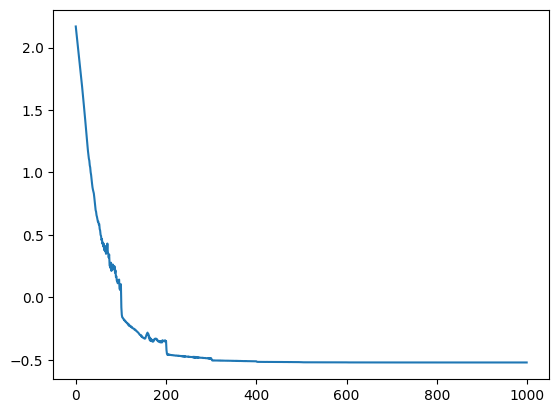

In [16]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [17]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.1971e-01, -1.7766e-01, -2.2868e-01, -1.1499e-01, -1.4636e-01,
          4.7469e-07, -1.9375e-01, -9.5370e-02, -1.8711e-01,  1.7894e-01,
         -3.0487e-06, -3.3123e-07, -2.4504e-06, -4.9501e-07,  1.4506e-06,
          2.8576e-06, -1.6422e-06, -2.8666e-07, -2.7545e-07,  2.0343e-06,
          2.5913e-06, -1.1383e-06, -2.7316e-06,  4.9918e-05, -9.7648e-07,
         -3.0549e-06,  3.0926e-06, -2.3171e-06, -2.6477e-06,  2.7246e-06,
         -2.0031e-06,  2.9029e-06,  1.9690e-06, -3.1061e-06,  3.7904e-07,
         -1.3074e-06, -6.1657e-07,  1.3928e-06, -7.2519e-07, -2.2741e-07,
         -6.1222e-07,  5.9591e-07, -2.2803e-06,  1.6997e-07,  1.5225e-06,
          2.6952e-07,  2.5088e-06,  2.1049e-07, -3.2452e-06, -6.5574e-07,
          1.5072e-06, -1.3380e-06,  2.8420e-06,  1.0806e-06, -1.6461e-06,
          3.2335e-06, -1.8456e-06,  3.5077e-06,  4.0721e-07,  2.7680e-06,
          3.0350e-06, -1.1815e-06,  1.1708e-06,  6.2124e-07,  8.9530e-07,
         -4.8539e-07,  4.7005e-07,  2.

tensor([[-1.1971e-01, -1.7766e-01, -2.2868e-01, -1.1499e-01, -1.4636e-01,
          4.7469e-07, -1.9375e-01, -9.5370e-02, -1.8711e-01,  1.7894e-01,
         -3.0487e-06, -3.3123e-07, -2.4504e-06, -4.9501e-07,  1.4506e-06,
          2.8576e-06, -1.6422e-06, -2.8666e-07, -2.7545e-07,  2.0343e-06,
          2.5913e-06, -1.1383e-06, -2.7316e-06,  4.9918e-05, -9.7648e-07,
         -3.0549e-06,  3.0926e-06, -2.3171e-06, -2.6477e-06,  2.7246e-06,
         -2.0031e-06,  2.9029e-06,  1.9690e-06, -3.1061e-06,  3.7904e-07,
         -1.3074e-06, -6.1657e-07,  1.3928e-06, -7.2519e-07, -2.2741e-07,
         -6.1222e-07,  5.9591e-07, -2.2803e-06,  1.6997e-07,  1.5225e-06,
          2.6952e-07,  2.5088e-06,  2.1049e-07, -3.2452e-06, -6.5574e-07,
          1.5072e-06, -1.3380e-06,  2.8420e-06,  1.0806e-06, -1.6461e-06,
          3.2335e-06, -1.8456e-06,  3.5077e-06,  4.0721e-07,  2.7680e-06,
          3.0350e-06, -1.1815e-06,  1.1708e-06,  6.2124e-07,  8.9530e-07,
         -4.8539e-07,  4.7005e-07,  2.

tensor([[-1.5536e-01,  2.2428e-01, -2.9195e-01, -9.7675e-02,  2.3676e-01,
         -2.9276e-07, -1.7340e-01, -1.6751e-01, -2.0110e-01, -2.6681e-01,
         -6.9783e-07,  1.0091e-07,  3.4520e-07,  2.3936e-07,  4.1844e-08,
          2.0370e-07, -2.8536e-07,  1.0834e-07, -1.2882e-07, -2.2303e-07,
         -6.7445e-09, -1.7471e-07,  1.8536e-07,  4.7545e-03, -2.3284e-07,
         -7.4401e-08,  6.3018e-08,  1.4989e-07, -2.4485e-08, -2.2524e-07,
         -2.1634e-07,  1.5121e-07,  5.1589e-08,  1.7453e-07, -7.9642e-08,
          2.8762e-07,  5.6954e-08,  5.2329e-08, -6.1781e-07,  1.0251e-07,
         -8.4174e-09,  2.8146e-08, -3.9290e-10, -2.8517e-08,  6.7816e-07,
         -2.1541e-06,  2.2897e-07, -2.1875e-07,  8.5970e-08, -2.7612e-08,
         -1.1875e-06, -3.4284e-09, -1.3340e-07, -5.2366e-09, -7.4263e-07,
         -1.3585e-06, -2.8689e-09,  1.5359e-06,  1.9205e-08,  5.9481e-08,
          1.3316e-08, -1.3114e-06, -2.8336e-07, -6.4437e-08, -3.4114e-08,
          7.2212e-07, -2.6470e-07, -1.

(raylet) [2022-11-17 12:20:19,694 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 29732864; capacity: 29394726912. Object creation will fail if spilling is required.


In [18]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([1.8986e-04, 8.4949e-01, 9.8913e-01, 5.8771e-01, 9.6475e-01, 7.6389e-04,
        9.4144e-01, 9.7244e-01, 1.3818e-02, 7.8431e-02, 9.7645e-01, 6.0072e-01,
        9.9449e-01, 1.3754e-01, 9.2016e-01, 8.1848e-04, 1.8911e-01, 9.0710e-02,
        9.8337e-01, 8.2614e-01, 9.2260e-01, 4.0509e-03, 9.8671e-01, 5.1452e-01,
        4.7149e-03, 9.9586e-03, 9.8869e-01, 9.7693e-01, 9.2818e-01, 9.1872e-01,
        2.7489e-01, 9.9249e-01, 9.8622e-01, 1.9402e-01, 9.4318e-01, 4.2767e-01,
        2.6258e-05, 4.5015e-02, 2.1824e-02, 8.8084e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 1.])

tensor([9.4717e-01, 9.8018e-01, 2.3357e-02, 7.7076e-02, 1.2072e-01, 9.3101e-01,
        8.0771e-01, 2.5812e-01, 9.1950e-01, 6.2887e-02, 3.9477e-02, 9.9073e-01,
        2.4860e-01, 2.6591e-05, 9.9860e-01, 9.8735e-01, 6.0073e-01, 1.0885e-01,
        9.9762e-01, 8.0144e-01, 9.7563e-01, 9.2365e-01, 1.8015e-01, 9.2085e-03,
        4.6117e-01, 9.6371e-01, 9.2929e-01, 4.5262e-05, 9.5226e-04, 5.4967e-01,
        1.4698e-02, 9.8812e-01, 9.9745e-01, 4.0948e-03, 8.6361e-01, 9.9591e-01,
        9.3673e-01, 3.9641e-02, 9.9906e-01, 1.0580e-02],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0.])

tensor([7.3841e-05, 2.4341e-02, 3.0135e-02, 9.9158e-01, 9.8938e-01, 2.8855e-01,
        4.3211e-01, 7.1348e-01, 4.8114e-03, 4.0421e-04, 9.7580e-01, 5.0264e-01,
        9.9819e-01, 8.8295e-01, 1.1072e-03, 9.9228e-01, 9.7811e-01, 5.6087e-01,
        7.8887e-01, 2.3475e-02, 9.9497e-01, 4.1058e-02, 1.5707e-02, 9.9481e-01,
        9.6563e-01, 1.0093e-05, 1.8839e-03, 8.1005e-01, 3.2971e-01, 7.5683e-03,
        9.9386e-01, 9.9539e-01, 9.9431e-01, 9.2423e-01, 8.5513e-01, 9.7021e-01,
        7.9455e-03, 4.5172e-01, 9.4788e-01, 3.2208e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 0.])

In [19]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[44,  6],
       [ 9, 61]])

0.8714285714285714

0.88

0.875

0.9104477611940298

0.8905109489051095

In [20]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[14,  1],
       [ 3, 22]])

0.88

0.9333333333333333

array([[14,  4],
       [ 4, 18]])

0.8181818181818182

0.7777777777777778

array([[16,  1],
       [ 2, 21]])

0.9130434782608695

0.9411764705882353

(raylet) [2022-11-17 12:20:29,703 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 29462528; capacity: 29394726912. Object creation will fail if spilling is required.


In [23]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.1971329e-01, -1.7765631e-01, -2.2868329e-01, -1.1499442e-01,
        -1.4636101e-01,  4.7468856e-07, -1.9375187e-01, -9.5370188e-02,
        -1.8711083e-01,  1.7894040e-01, -3.0486933e-06, -3.3123240e-07,
        -2.4503670e-06, -4.9501415e-07,  1.4506390e-06,  2.8575548e-06,
        -1.6422420e-06, -2.8665784e-07, -2.7544812e-07,  2.0343307e-06,
         2.5912811e-06, -1.1383000e-06, -2.7316128e-06,  4.9918493e-05,
        -9.7647603e-07, -3.0548520e-06,  3.0925582e-06, -2.3170658e-06,
        -2.6476753e-06,  2.7246449e-06, -2.0030780e-06,  2.9029020e-06,
         1.9689783e-06, -3.1060968e-06,  3.7903669e-07, -1.3074414e-06,
        -6.1657192e-07,  1.3928192e-06, -7.2518958e-07, -2.2740863e-07,
        -6.1221925e-07,  5.9590928e-07, -2.2803395e-06,  1.6996573e-07,
         1.5225453e-06,  2.6952344e-07,  2.5088191e-06,  2.1049070e-07,
        -3.2452308e-06, -6.5574062e-07,  1.5072342e-06, -1.3380097e-06,
         2.8419813e-06,  1.0806458e-06, -1.6460807e-06,  3.23350

array([[-1.1971329e-01, -1.7765631e-01, -2.2868329e-01, -1.1499442e-01,
        -1.4636101e-01,  4.7468856e-07, -1.9375187e-01, -9.5370188e-02,
        -1.8711083e-01,  1.7894040e-01, -3.0486933e-06, -3.3123240e-07,
        -2.4503670e-06, -4.9501415e-07,  1.4506390e-06,  2.8575548e-06,
        -1.6422420e-06, -2.8665784e-07, -2.7544812e-07,  2.0343307e-06,
         2.5912811e-06, -1.1383000e-06, -2.7316128e-06,  4.9918493e-05,
        -9.7647603e-07, -3.0548520e-06,  3.0925582e-06, -2.3170658e-06,
        -2.6476753e-06,  2.7246449e-06, -2.0030780e-06,  2.9029020e-06,
         1.9689783e-06, -3.1060968e-06,  3.7903669e-07, -1.3074414e-06,
        -6.1657192e-07,  1.3928192e-06, -7.2518958e-07, -2.2740863e-07,
        -6.1221925e-07,  5.9590928e-07, -2.2803395e-06,  1.6996573e-07,
         1.5225453e-06,  2.6952344e-07,  2.5088191e-06,  2.1049070e-07,
        -3.2452308e-06, -6.5574062e-07,  1.5072342e-06, -1.3380097e-06,
         2.8419813e-06,  1.0806458e-06, -1.6460807e-06,  3.23350

array([[-1.5535824e-01,  2.2427706e-01, -2.9194602e-01, -9.7674727e-02,
         2.3676014e-01, -2.9275702e-07, -1.7340419e-01, -1.6750556e-01,
        -2.0109844e-01, -2.6680800e-01, -6.9782584e-07,  1.0091179e-07,
         3.4519920e-07,  2.3936289e-07,  4.1844419e-08,  2.0369527e-07,
        -2.8535891e-07,  1.0833737e-07, -1.2881914e-07, -2.2303354e-07,
        -6.7445169e-09, -1.7470893e-07,  1.8536292e-07,  4.7544660e-03,
        -2.3283974e-07, -7.4401484e-08,  6.3017708e-08,  1.4989216e-07,
        -2.4485479e-08, -2.2523770e-07, -2.1633547e-07,  1.5120554e-07,
         5.1589051e-08,  1.7453114e-07, -7.9642071e-08,  2.8762065e-07,
         5.6953809e-08,  5.2328936e-08, -6.1780963e-07,  1.0251018e-07,
        -8.4173921e-09,  2.8145612e-08, -3.9290024e-10, -2.8517368e-08,
         6.7816171e-07, -2.1541155e-06,  2.2897260e-07, -2.1874841e-07,
         8.5970314e-08, -2.7611824e-08, -1.1875370e-06, -3.4283851e-09,
        -1.3339790e-07, -5.2365512e-09, -7.4262789e-07, -1.35853

In [25]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.11971329, -0.17765631, -0.2286833 , -0.11499442, -0.14636101,
         0.        , -0.19375187, -0.09537019, -0.18711083,  0.1789404 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 95])

10

(raylet) [2022-11-17 12:20:59,731 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 29016064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:21:09,739 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 28966912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:21:19,748 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 28901376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:21:29,757 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 28635136; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-11-17 12:26:10,016 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 24739840; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:26:20,026 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 24666112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:26:30,034 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 24403968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:26:40,044 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 24141824; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-11-17 12:31:20,296 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 20484096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:31:30,304 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 20209664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:31:40,314 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 19931136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:31:50,322 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 19873792; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-11-17 12:36:30,579 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 16027648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:36:40,588 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 15757312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:36:50,597 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 15699968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:37:00,606 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 15605760; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-11-17 12:41:40,889 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 11603968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:41:50,899 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 11530240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:42:00,908 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 11415552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:42:10,918 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 11350016; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-11-17 12:46:51,167 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 7352320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:47:01,177 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 7294976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:47:11,186 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 7217152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:47:21,195 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 7163904; capacity: 29394726912. Object creation will fail if spilling is requir

(raylet) [2022-11-17 12:52:11,475 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 3059712; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:52:21,485 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 2990080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:52:31,493 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 2699264; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-17 12:52:41,503 E 6648 6666] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-17_12-13-27_249981_6051 is over 95% full, available space: 2433024; capacity: 29394726912. Object creation will fail if spilling is requir